# 1 Configuration

## 1.1 Import Libraries

In [2]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib as matplot
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

print("Python ver: {}".format(sys.version))
print("Numpy ver: {}".format(np.__version__))
print("Pandas ver: {}".format(pd.__version__))
print("MatPlotLib ver: {}".format(matplot.__version__))
print("SeaBorn ver: {}".format(sns.__version__))
print("StatsModel ver: {}".format(sm.__version__))
print("Scipy ver: {}".format(scipy.__version__))
print("SkLearn ver: {}".format(sklearn.__version__))

Python ver: 3.9.1 (default, Jan 21 2021, 16:04:12) 
[Clang 12.0.0 (clang-1200.0.32.28)]
Numpy ver: 1.19.5
Pandas ver: 1.1.4
MatPlotLib ver: 3.3.3
SeaBorn ver: 0.11.1
StatsModel ver: 0.12.1
Scipy ver: 1.5.4
SkLearn ver: 0.24.1


In [3]:
def heatMap(df,max=1,min=-1):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(df, dtype=bool),1)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df, mask=mask, cmap=cmap, vmax=max, center=(max+min)/2, vmin=min,
                square=True, annot=True, linewidths=.2, cbar_kws={"shrink": .5})

    # Show the plot
    plt.show()
    
def checkCorrectness(df,originalLabel,predictedLabel):
    correct = len(df[(df[originalLabel] == df[predictedLabel])])
    incorrect = len(df) - correct
    return (correct,incorrect,(correct*100/(correct+incorrect)))

## 1.2 Pre configurations

In [4]:
import warnings

# Set Seaborn theme
sns.set_theme(color_codes=True)

# Disable warnings
warnings.simplefilter("ignore")

# 2 Data Preparation

## 2.1 Load the data

In [5]:
AimoScoreFileUrl = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/AimoScore_WeakLink_big_scores.xls"
WeakLinksFileUrl = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/20190108%20scores_and_weak_links.xlsx"

try:
    AimoScore = pd.read_excel(AimoScoreFileUrl, engine=None)
    WeakLinks = pd.read_excel(WeakLinksFileUrl, engine='openpyxl')

except IOError as e:
    print(e)


## 2.2 Merging the two datasets

### 2.2.1 Join the two tables via their ID

In [6]:
print("AimoScore size: {}".format(len(AimoScore)))
print("WeakLinks size: {}".format(len(WeakLinks)))
result = pd.merge(AimoScore, WeakLinks,on=["ID"])
print("result size: {}".format(len(result)))

AimoScore size: 2094
WeakLinks size: 2096
result size: 2094


### 2.2.2 Find the weakest link for each data point
Finding the column with the maximum score in each row and adding its name as a new column

In [7]:
result["WeakLinks"] = result.loc[:,"ForwardHead":"RightHeelRises"].idxmax(axis=1)

### 2.2.3 Discard extra columns
Discard the 14 weak link scores from the joint table

In [8]:
result.drop(result.columns.to_series()["ForwardHead":"RightHeelRises"], axis=1, inplace=True)

### 2.2.4 Remove Duplicates

In [9]:
result = result.drop_duplicates(subset="ID")

In [10]:
result["WeakLinks"].value_counts()

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: WeakLinks, dtype: int64

### 2.2.5 Remove clusters with very few samples 

In [11]:
temp = (result["WeakLinks"].value_counts()<10)
temp = temp[~temp == False]
result = result[~result["WeakLinks"].isin(temp.index)]
result["WeakLinks"].value_counts()

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
Name: WeakLinks, dtype: int64

In [12]:
result[["ID","SCORE","AimoScore","WeakLinks"]]

,ID,SCORE,AimoScore,WeakLinks
0,0003cdcc-86ed-494a-a3b5-90d09e96e06b.Kinect,0.323667,0.323667,RightShoulderElevation
1,003115c4-bdb8-491c-b571-8fcebdecf8ed.Kinect,0.323699,0.323699,RightArmFallForward
2,00316bfb-ed43-489f-a55b-11c7f01c852d.Kinect,0.848327,0.848327,LeftArmFallForward
3,00607608-6f2f-459b-a69d-e14067489459.Kinect,0.351332,0.351332,RightShoulderElevation
4,007396ec-3463-4a05-915c-02244ff8d3de.Kinect,0.627181,0.627181,ForwardHead
...,...,...,...,...
2086,feca4c0e-cbc7-4e5e-b85c-8befedbc65a4.Kinect,0.665494,0.665494,RightArmFallForward
2087,fed923af-f41e-42bc-8799-3a9f8a5f2129.Kinect,0.830883,0.830883,LeftArmFallForward
2088,ff015ddd-c9fb-49e3-8e33-abbf72e8b120.Kinect,0.527640,0.527640,LeftArmFallForward
2090,ff514cba-6c5e-41a9-9936-3e8400565c8d.Kinect,0.407197,0.407197,RightKneeMovesOutward


### Testing and Traing sets

In [47]:
from sklearn.model_selection import train_test_split

trainingPercent = 0.9

y_train,y_test ,X_train, X_test  = train_test_split(result[["WeakLinks"]], result.drop(columns=["WeakLinks","AimoScore","SCORE","ID","Date", "EstimatedScore"]), train_size = trainingPercent)

In [50]:
X_test.columns

NameError: name 'count' is not defined

### Logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression

model_3 = LogisticRegression(solver='liblinear', C=25.0, random_state=0)
result_3 = model_3.fit(X_train, y_train)

print('Classes: ',result_3.classes_)
print('Intercept :', result_3.intercept_)
print('Coefficeients: ',result_3.coef_)

Classes:  ['ExcessiveForwardLean' 'ForwardHead' 'LeftArmFallForward'
 'LeftAsymmetricalWeightShift' 'LeftKneeMovesOutward'
 'LeftShoulderElevation' 'RightArmFallForward'
 'RightAsymmetricalWeightShift' 'RightKneeMovesInward'
 'RightKneeMovesOutward' 'RightShoulderElevation']
Intercept : [-13.10885551 -18.15712917  -6.47600015  -6.53606875  -3.04184314
  -5.45406356  -3.45746944  -6.86182241   2.31093492  -0.83792263
   2.36469593]
Coefficeients:  [[-1.10589711e-01  1.17108111e+00 -3.23312906e+00  1.56244226e+00
  -1.15793331e+00  6.89278965e-02 -2.22375197e-01  3.38436789e+00
  -1.11742188e+00  1.51672325e+00 -2.35511993e+00  3.54467100e-01
  -7.40736331e-01 -1.15793331e+00 -2.22375197e-01 -1.10589711e-01
   1.51672325e+00 -7.40736331e-01 -3.06308035e+00 -2.11725257e-01
   3.79575427e-01 -2.17249322e+00  1.88387663e+01 -1.40210897e+00
   8.29095985e-01  1.11643843e+00  2.85138924e-01  1.63640071e-01
  -4.04240276e-01  1.53960415e+00 -1.45748676e+00 -2.38189266e+00
   1.87023220e+00  1.

In [16]:
prob = result_3.predict_proba(X_test)

# Find maximum value from probability prediction array
maxValues = pd.DataFrame(prob, columns = range(0,11))

# Dominant WeakLink
dominant = result_3.classes_[maxValues.idxmax(axis=1, skipna=True)]

comparison = pd.DataFrame({'Original': y_test.WeakLinks, 'Dominant':dominant})
comparison

,Original,Dominant
805,ForwardHead,LeftArmFallForward
836,RightArmFallForward,RightArmFallForward
2029,RightArmFallForward,RightArmFallForward
1689,RightArmFallForward,RightArmFallForward
2016,RightArmFallForward,RightArmFallForward
...,...,...
308,RightAsymmetricalWeightShift,LeftArmFallForward
153,RightArmFallForward,RightArmFallForward
1619,RightArmFallForward,RightArmFallForward
514,LeftArmFallForward,RightArmFallForward


In [17]:
c,e,p = checkCorrectness(comparison,"Original","Dominant")

print("correct:" + str(c))
print("incorrect:" + str(e))
print("percentage:" + str(p))

correct:124
incorrect:85
percentage:59.33014354066986


In [18]:
# Save champion model
import joblib

joblib.dump(result_3, "logistic_regression.joblib")

['logistic_regression.joblib']

In [19]:
confusion_matrix = comparison.groupby(['Dominant','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Dominant,,,,,,,,,,,
ExcessiveForwardLean,9.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
ForwardHead,0.0,8.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
LeftArmFallForward,1.0,2.0,43.0,2.0,0.0,1.0,21.0,2.0,1.0,1.0,1.0
LeftAsymmetricalWeightShift,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
LeftKneeMovesOutward,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
LeftShoulderElevation,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
RightArmFallForward,3.0,4.0,11.0,0.0,2.0,1.0,29.0,0.0,0.0,0.0,4.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
RightKneeMovesOutward,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,22.0,0.0


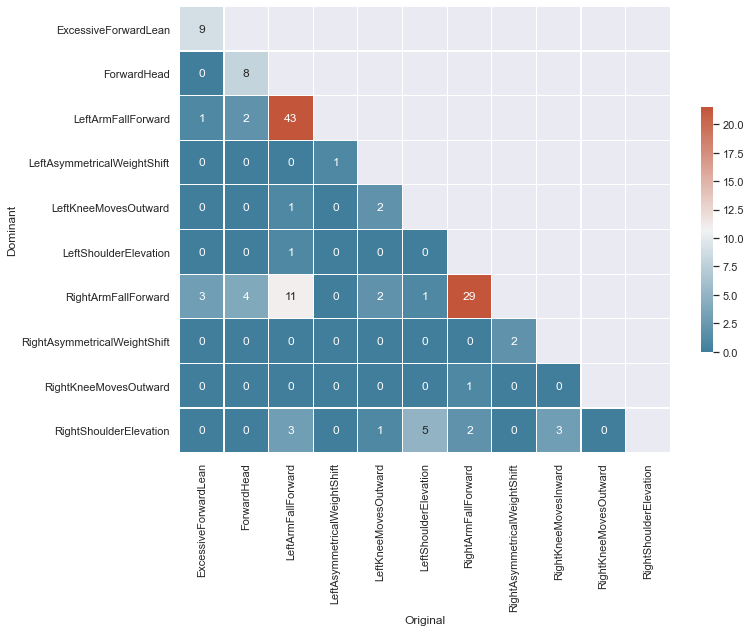

In [20]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### LDA (Linear Discriminant Analysis)

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_4 = LinearDiscriminantAnalysis()
result_4 = model_4.fit(X_train, y_train)

print(result_4.classes_)
print(result_4.priors_)
print(result_4.means_)
print(result_4.coef_)

['ExcessiveForwardLean' 'ForwardHead' 'LeftArmFallForward'
 'LeftAsymmetricalWeightShift' 'LeftKneeMovesOutward'
 'LeftShoulderElevation' 'RightArmFallForward'
 'RightAsymmetricalWeightShift' 'RightKneeMovesInward'
 'RightKneeMovesOutward' 'RightShoulderElevation']
[0.04637527 0.0533049  0.30277186 0.03624733 0.02292111 0.02665245
 0.22228145 0.00746269 0.02185501 0.13432836 0.12579957]
[[0.70729509 0.76363946 0.52454141 0.66503955 0.40210646 0.64650912
  0.38266902 0.8228203  0.44492818 0.5821501  0.77233024 0.46449205
  0.5876691  0.40210646 0.38266902 0.70729509 0.5821501  0.5876691
  0.62405383 0.58521743 0.74527394 0.7186684  0.93742751 0.55894721
  0.54239021 0.69340413 0.50405405 0.57511393 0.48249476 0.71235234
  0.65007668 0.75109528 0.72080674 0.74642832 0.67933728 0.70254017
  0.63770841 0.56323488 0.51575169 0.53263851 0.58606397]
 [0.66087996 0.65697752 0.71950263 0.57262076 0.54068867 0.49549976
  0.5526351  0.70776662 0.43900048 0.4084792  0.7292396  0.35439981
  0.41424

In [22]:
y_pred=model_4.predict(X_test)

In [23]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,
                        'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,11.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ForwardHead,0.0,12.0,0.0,3.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0
LeftArmFallForward,0.0,2.0,39.0,1.0,0.0,1.0,19.0,0.0,0.0,1.0,0.0
LeftAsymmetricalWeightShift,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
LeftKneeMovesOutward,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
LeftShoulderElevation,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
RightArmFallForward,1.0,1.0,12.0,0.0,2.0,1.0,23.0,0.0,0.0,0.0,1.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
RightKneeMovesInward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


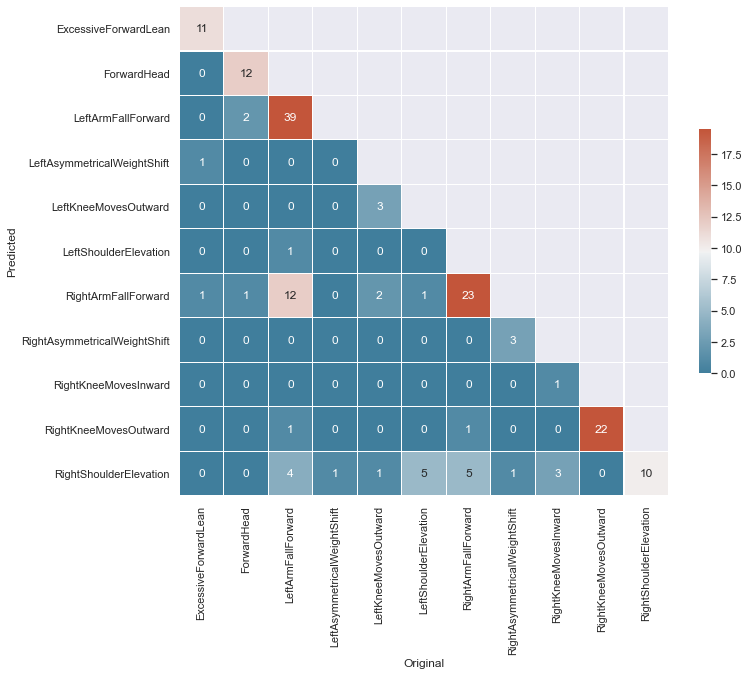

In [24]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[11  0  3  0  0  0  1  0  0  0  0]
 [ 0 12  0  3  0  0  4  1  0  0  1]
 [ 0  2 39  1  0  1 19  0  0  1  0]
 [ 1  0  0  0  0  1  1  0  0  0  1]
 [ 0  0  0  0  3  0  0  0  0  0  1]
 [ 0  0  1  0  0  0  1  0  0  1  0]
 [ 1  1 12  0  2  1 23  0  0  0  1]
 [ 0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  1  0  0  0  1  0  0 22  0]
 [ 0  0  4  1  1  5  5  1  3  0 10]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.733     0.846     0.786        13
                 ForwardHead      0.571     0.800     0.667        15
          LeftArmFallForward      0.619     0.650     0.634        60
 LeftAsymmetricalWeightShift      0.000     0.000     0.000         5
        LeftKneeMovesOutward      0.750     0.500     0.600         6
       LeftShoulderElevation      0.000     0.000     0.000         8
         RightArmFallForward      0.561     0.418     0.479        55
RightAsymmetricalWeightShift      1.000   

### QDA

In [26]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model_5 = QuadraticDiscriminantAnalysis()
result_5 = model_5.fit(X_train, y_train)

print(result_5.priors_)
print(result_5.means_)

[0.04637527 0.0533049  0.30277186 0.03624733 0.02292111 0.02665245
 0.22228145 0.00746269 0.02185501 0.13432836 0.12579957]
[[0.70729509 0.76363946 0.52454141 0.66503955 0.40210646 0.64650912
  0.38266902 0.8228203  0.44492818 0.5821501  0.77233024 0.46449205
  0.5876691  0.40210646 0.38266902 0.70729509 0.5821501  0.5876691
  0.62405383 0.58521743 0.74527394 0.7186684  0.93742751 0.55894721
  0.54239021 0.69340413 0.50405405 0.57511393 0.48249476 0.71235234
  0.65007668 0.75109528 0.72080674 0.74642832 0.67933728 0.70254017
  0.63770841 0.56323488 0.51575169 0.53263851 0.58606397]
 [0.66087996 0.65697752 0.71950263 0.57262076 0.54068867 0.49549976
  0.5526351  0.70776662 0.43900048 0.4084792  0.7292396  0.35439981
  0.41424199 0.54068867 0.5526351  0.66087996 0.4084792  0.41424199
  0.55761358 0.94276423 0.55840746 0.53990435 0.59621234 0.51482544
  0.52386418 0.61830703 0.40832616 0.63011478 0.44284553 0.77194165
  0.55604017 0.74864658 0.6878814  0.69157819 0.6370923  0.71511717
  0

In [27]:
y_pred=model_5.predict(X_test)

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[ 8  3  3  0  0  0  2  1  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7 28  3  5  2 16  2  1  2  7]
 [ 0  0  1  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 5  4 22  1  1  1 33  0  1  2  4]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  0]
 [ 0  1  6  1  0  3  4  2  2  1  2]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.444     0.615     0.516        13
                 ForwardHead      0.000     0.000     0.000        15
          LeftArmFallForward      0.384     0.467     0.421        60
 LeftAsymmetricalWeightShift      0.000     0.000     0.000         5
        LeftKneeMovesOutward      0.000     0.000     0.000         6
       LeftShoulderElevation      0.000     0.000     0.000         8
         RightArmFallForward      0.446     0.600     0.512        55
RightAsymmetricalWeightShift      0.000   

In [29]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,8.0,3.0,3.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0
LeftArmFallForward,0.0,7.0,28.0,3.0,5.0,2.0,16.0,2.0,1.0,2.0,7.0
LeftAsymmetricalWeightShift,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
RightArmFallForward,5.0,4.0,22.0,1.0,1.0,1.0,33.0,0.0,1.0,2.0,4.0
RightKneeMovesOutward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0
RightShoulderElevation,0.0,1.0,6.0,1.0,0.0,3.0,4.0,2.0,2.0,1.0,2.0


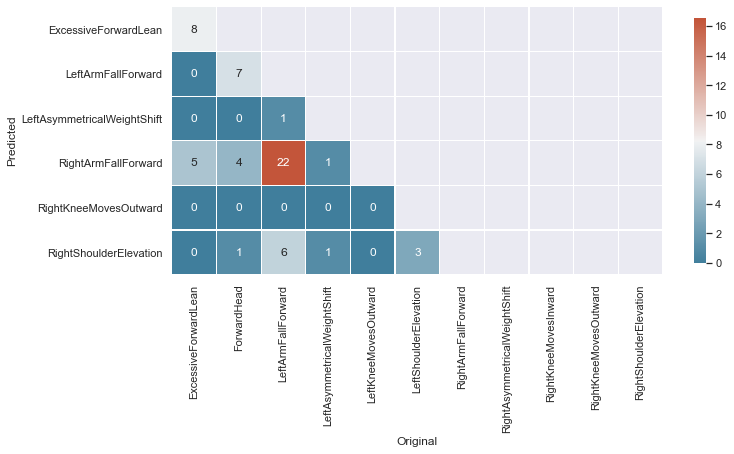

In [30]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=1

In [31]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_6 = neighbors.KNeighborsClassifier(n_neighbors=1)
result_6 = model_6.fit(X_train, y_train)
y_pred = result_6.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[ 7  3  3  0  0  1  1  0  0  0  0]
 [ 1  3  1  1  0  0  2  0  0  0  0]
 [ 2  3 29  1  1  3 16  0  0  1  1]
 [ 0  0  1  1  0  0  1  0  0  0  0]
 [ 0  0  1  0  3  1  2  0  1  0  0]
 [ 1  0  0  0  0  0  0  0  1  0  1]
 [ 1  6 17  1  2  0 29  1  1  0  1]
 [ 0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  1]
 [ 0  0  1  0  0  0  2  0  0 22  0]
 [ 1  0  7  1  0  3  2  3  0  1 10]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.467     0.538     0.500        13
                 ForwardHead      0.375     0.200     0.261        15
          LeftArmFallForward      0.509     0.483     0.496        60
 LeftAsymmetricalWeightShift      0.333     0.200     0.250         5
        LeftKneeMovesOutward      0.375     0.500     0.429         6
       LeftShoulderElevation      0.000     0.000     0.000         8
         RightArmFallForward      0.492     0.527     0.509        55
RightAsymmetricalWeightShift      1.000   

In [32]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,7.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
ForwardHead,1.0,3.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
LeftArmFallForward,2.0,3.0,29.0,1.0,1.0,3.0,16.0,0.0,0.0,1.0,1.0
LeftAsymmetricalWeightShift,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
LeftKneeMovesOutward,0.0,0.0,1.0,0.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0
LeftShoulderElevation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
RightArmFallForward,1.0,6.0,17.0,1.0,2.0,0.0,29.0,1.0,1.0,0.0,1.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
RightKneeMovesInward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


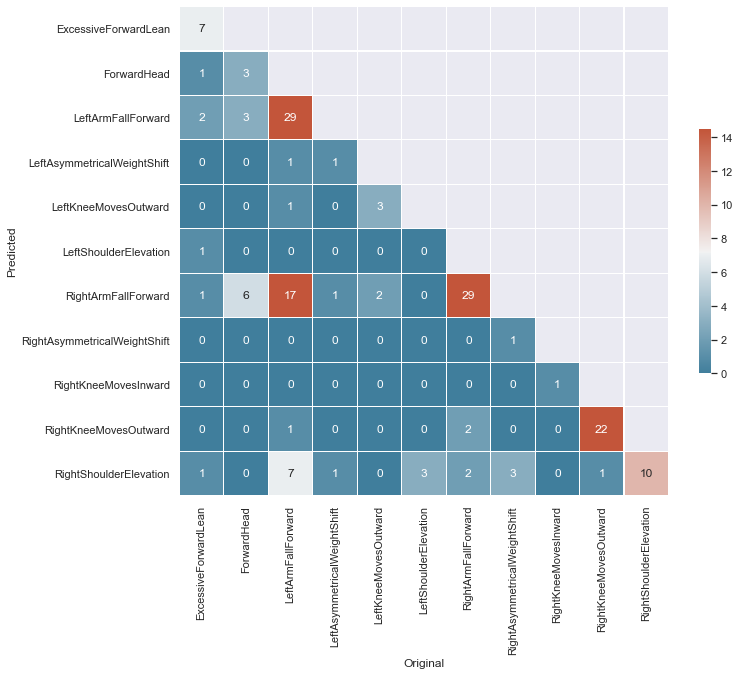

In [33]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=2

In [34]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_7 = neighbors.KNeighborsClassifier(n_neighbors=2)
result_7 = model_7.fit(X_train, y_train)
y_pred = result_7.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[ 9  3  4  0  0  1  2  0  0  0  0]
 [ 0  6  1  1  1  1  4  0  0  0  0]
 [ 1  3 39  2  1  2 27  2  0  1  1]
 [ 1  0  2  1  0  0  1  1  0  0  0]
 [ 0  0  1  0  4  1  2  0  1  0  1]
 [ 1  0  0  0  0  0  1  0  1  1  1]
 [ 1  3  9  0  0  1 16  0  2  0  4]
 [ 0  0  0  0  0  1  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  1  0  0  0  1  0  0 22  0]
 [ 0  0  3  1  0  1  1  1  0  0  6]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.474     0.692     0.562        13
                 ForwardHead      0.429     0.400     0.414        15
          LeftArmFallForward      0.494     0.650     0.561        60
 LeftAsymmetricalWeightShift      0.167     0.200     0.182         5
        LeftKneeMovesOutward      0.400     0.667     0.500         6
       LeftShoulderElevation      0.000     0.000     0.000         8
         RightArmFallForward      0.444     0.291     0.352        55
RightAsymmetricalWeightShift      0.500   

In [35]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,9.0,3.0,4.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
ForwardHead,0.0,6.0,1.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0
LeftArmFallForward,1.0,3.0,39.0,2.0,1.0,2.0,27.0,2.0,0.0,1.0,1.0
LeftAsymmetricalWeightShift,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
LeftKneeMovesOutward,0.0,0.0,1.0,0.0,4.0,1.0,2.0,0.0,1.0,0.0,1.0
LeftShoulderElevation,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
RightArmFallForward,1.0,3.0,9.0,0.0,0.0,1.0,16.0,0.0,2.0,0.0,4.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
RightKneeMovesInward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


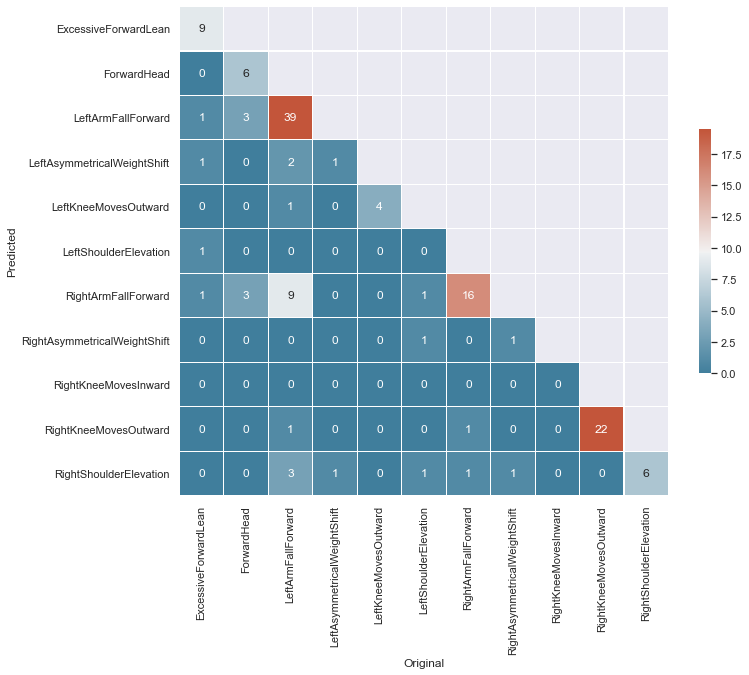

In [36]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=3

In [37]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_7 = neighbors.KNeighborsClassifier(n_neighbors=3)
result_7 = model_7.fit(X_train, y_train)
y_pred = result_7.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[10  3  5  0  0  1  2  0  0  0  0]
 [ 0  7  1  1  1  1  3  1  0  0  0]
 [ 1  2 32  2  1  1 14  1  1  1  2]
 [ 1  0  1  1  0  1  1  1  0  0  0]
 [ 0  0  2  0  4  1  1  0  1  0  1]
 [ 0  0  0  0  0  0  1  0  1  1  2]
 [ 1  3 12  0  0  0 30  0  1  0  2]
 [ 0  0  0  0  0  1  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  1  0  0 22  0]
 [ 0  0  6  1  0  2  2  1  0  0  7]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.476     0.769     0.588        13
                 ForwardHead      0.467     0.467     0.467        15
          LeftArmFallForward      0.552     0.533     0.542        60
 LeftAsymmetricalWeightShift      0.167     0.200     0.182         5
        LeftKneeMovesOutward      0.400     0.667     0.500         6
       LeftShoulderElevation      0.000     0.000     0.000         8
         RightArmFallForward      0.612     0.545     0.577        55
RightAsymmetricalWeightShift      0.500   

In [38]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,10.0,3.0,5.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
ForwardHead,0.0,7.0,1.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0
LeftArmFallForward,1.0,2.0,32.0,2.0,1.0,1.0,14.0,1.0,1.0,1.0,2.0
LeftAsymmetricalWeightShift,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
LeftKneeMovesOutward,0.0,0.0,2.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,1.0
LeftShoulderElevation,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0
RightArmFallForward,1.0,3.0,12.0,0.0,0.0,0.0,30.0,0.0,1.0,0.0,2.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
RightKneeMovesOutward,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,22.0,0.0


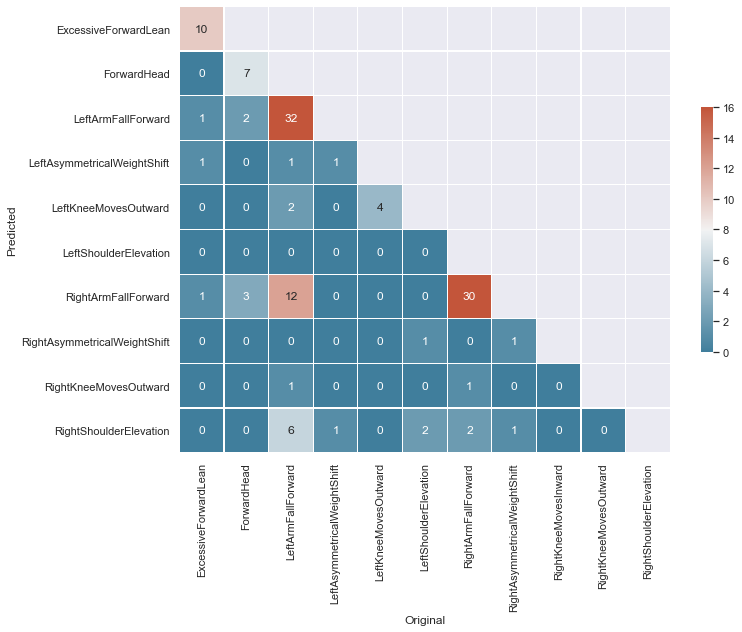

In [39]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=4

In [41]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_7 = neighbors.KNeighborsClassifier(n_neighbors=4)
result_7 = model_7.fit(X_train, y_train)
y_pred = result_7.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[10  4  5  0  0  1  2  0  0  0  0]
 [ 0  5  1  1  1  1  3  0  0  0  0]
 [ 2  3 37  1  0  1 16  1  1  1  2]
 [ 0  0  1  1  0  1  1  1  0  0  0]
 [ 0  0  1  0  4  1  0  0  1  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 1  3  7  0  1  1 28  1  1  0  3]
 [ 0  0  0  0  0  1  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  1  0  1 22  0]
 [ 0  0  7  2  0  1  4  1  0  1  8]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.455     0.769     0.571        13
                 ForwardHead      0.417     0.333     0.370        15
          LeftArmFallForward      0.569     0.617     0.592        60
 LeftAsymmetricalWeightShift      0.200     0.200     0.200         5
        LeftKneeMovesOutward      0.500     0.667     0.571         6
       LeftShoulderElevation      0.000     0.000     0.000         8
         RightArmFallForward      0.609     0.509     0.554        55
RightAsymmetricalWeightShift      0.500   

In [42]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,10.0,4.0,5.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
ForwardHead,0.0,5.0,1.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0
LeftArmFallForward,2.0,3.0,37.0,1.0,0.0,1.0,16.0,1.0,1.0,1.0,2.0
LeftAsymmetricalWeightShift,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
LeftKneeMovesOutward,0.0,0.0,1.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,1.0
RightArmFallForward,1.0,3.0,7.0,0.0,1.0,1.0,28.0,1.0,1.0,0.0,3.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
RightKneeMovesOutward,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,22.0,0.0
RightShoulderElevation,0.0,0.0,7.0,2.0,0.0,1.0,4.0,1.0,0.0,1.0,8.0


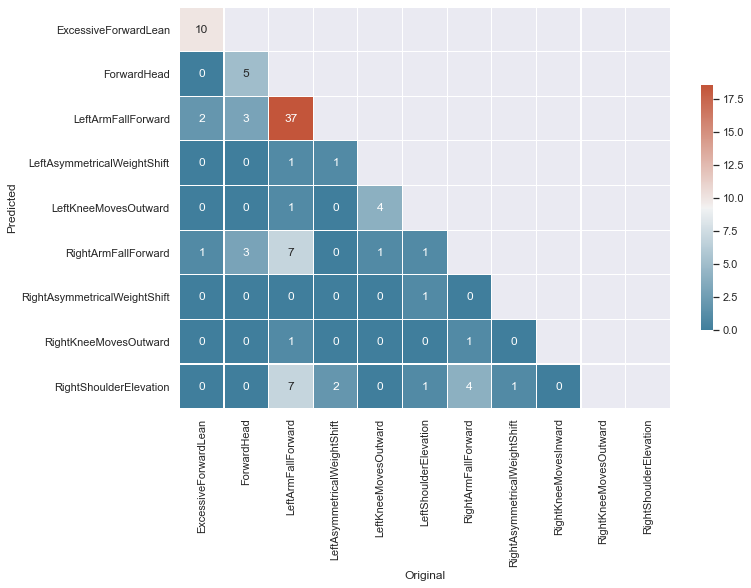

In [43]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=5

In [44]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_7 = neighbors.KNeighborsClassifier(n_neighbors=5)
result_7 = model_7.fit(X_train, y_train)
y_pred = result_7.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[ 9  3  6  0  0  0  2  0  0  0  0]
 [ 0  6  1  1  1  0  2  0  0  0  0]
 [ 2  3 36  1  0  2 16  3  1  1  2]
 [ 0  0  0  1  0  2  1  1  0  0  0]
 [ 0  0  1  0  4  1  2  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  1  0]
 [ 2  3 10  0  1  1 30  0  1  0  4]
 [ 0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  1  0  1 22  0]
 [ 0  0  6  2  0  2  1  0  1  0  6]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.450     0.692     0.545        13
                 ForwardHead      0.545     0.400     0.462        15
          LeftArmFallForward      0.537     0.600     0.567        60
 LeftAsymmetricalWeightShift      0.200     0.200     0.200         5
        LeftKneeMovesOutward      0.444     0.667     0.533         6
       LeftShoulderElevation      0.000     0.000     0.000         8
         RightArmFallForward      0.577     0.545     0.561        55
RightAsymmetricalWeightShift      1.000   

In [45]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,9.0,3.0,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
ForwardHead,0.0,6.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
LeftArmFallForward,2.0,3.0,36.0,1.0,0.0,2.0,16.0,3.0,1.0,1.0,2.0
LeftAsymmetricalWeightShift,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0
LeftKneeMovesOutward,0.0,0.0,1.0,0.0,4.0,1.0,2.0,0.0,0.0,0.0,1.0
LeftShoulderElevation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
RightArmFallForward,2.0,3.0,10.0,0.0,1.0,1.0,30.0,0.0,1.0,0.0,4.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
RightKneeMovesInward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


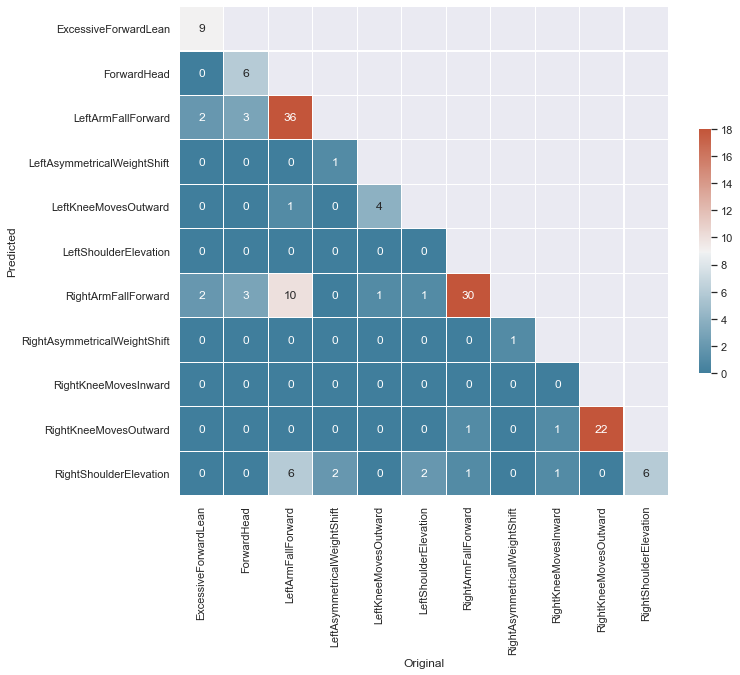

In [46]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)